In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
comps = pd.read_csv("data/all_comps.csv")
names = pd.read_csv("data/all_names.csv")
ratings = pd.read_csv("data/all_ratings.csv")
results = pd.read_csv("data/all_results.csv")
stats = pd.read_csv("data/all_stats.csv")

In [38]:
merged = results.merge(comps, on="id")

In [39]:
dataset = merged[['speed', 'dist', 'wind_comp', 'k-point', 'note_points']]

## Przebadajmy ogólne trendy w zależności od rodzaju skoczni

### Skocznie normalne

In [42]:
normal_hills = dataset[(dataset['k-point'] > 75) & (dataset['k-point'] < 100)].dropna()

[Text(0.5, 1.0, 'Skocznie normalne - korelacja')]

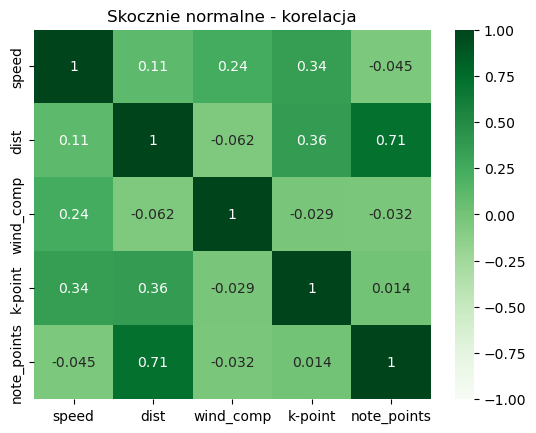

In [72]:
sns.heatmap(normal_hills.corr(), cmap='Greens', annot=True, vmin=-1, vmax=1).set(title="Skocznie normalne - korelacja")

### Skocznie duże

In [46]:
large_hills = dataset[(dataset['k-point'] > 100) & (dataset['k-point'] < 170)].dropna() # large hills

[Text(0.5, 1.0, 'Skocznie duże - korelacja')]

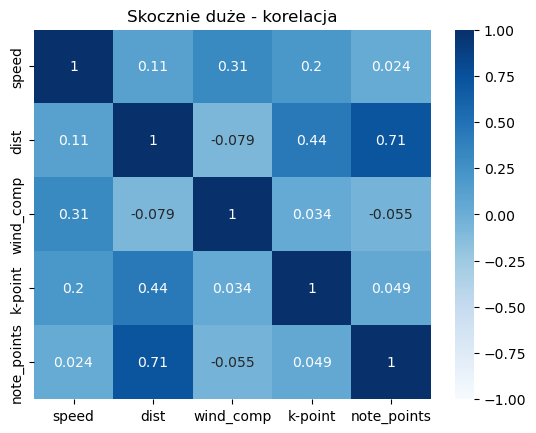

In [73]:
sns.heatmap(large_hills.corr(), cmap='Blues', annot=True, vmin=-1, vmax=1).set(title="Skocznie duże - korelacja")

### Skocznie mamucie

In [49]:
flying_hills = dataset[dataset['k-point'] > 170].dropna()

[Text(0.5, 1.0, 'Skocznie mamucie - korelacja')]

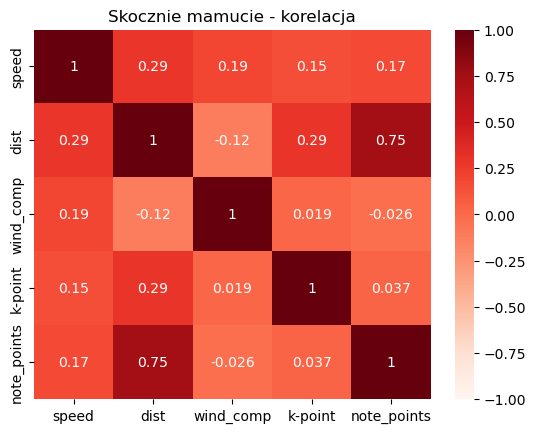

In [75]:
sns.heatmap(flying_hills.corr(), cmap='Reds', annot=True, vmin=-1, vmax=1).set(title="Skocznie mamucie - korelacja")

## Wnioski

Na podstawie macierzy korelacji można zauważyć, że bez względu na rodzaj skoczni istnieje silna zależność pomiędzy odległością uzyskaną
przez zawodników, a notami za styl. Jest to spowodowane tym, że sędziowie oceniając styl sugerują się
odległością i z automatu obniżają noty zawodnikom, którzy nie osiągają punktu konstrukcyjnego.

Inna zależność, jaką można wyczytać to wzrost wpływu wiatru na odległość zawodników w zależności od wielkości skoczni. Co ciekawe, nie jest on duży. Może mieć na to wpływ korekta rozbiegu podczas zawodów, co pozwala na zminimalizowanie wpływu wiatru na zawodników. Największa wartość współczynnik korelacji między wiatrem, a uzyskiwaną odległością występuje dla skoczni mamucich. Ma to odzwierciedlenie w praktyce, ponieważ na skoczniach mamucich wiatr wiejący pod narty daje większą korzyść, niż na skoczniach mniejszych.